# Text Classification - IMDB

# Imports 

In [1]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Global vairiables for script

cross_validation_iterations = 30


# Exploring the Dataset

In [3]:
filename = 'movie_data_cat.csv'
SPAM_dataframe = pd.read_csv(filename, encoding='utf-8')

In [4]:
SPAM_dataframe.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",pos
1,OK... so... I really like Kris Kristofferson a...,neg
2,"***SPOILER*** Do not read this, if you think a...",neg
3,hi for all the people who have seen this wonde...,pos
4,"I recently bought the DVD, forgetting just how...",neg


# Converting Class Index to int

In [5]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(SPAM_dataframe['sentiment']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later

{'neg': 0, 'pos': 1}


In [6]:
#use the mapping dictionary to transform the class labels into integers

SPAM_dataframe["sentiment"] = SPAM_dataframe["sentiment"].map(class_mapping)


In [7]:
SPAM_dataframe.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


# Cleaning up the Data

In [8]:
SPAM_dataframe.loc[42, 'review']#[-50:]

'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.'

In [9]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

In [10]:
preprocessor(SPAM_dataframe.loc[42, 'review'])#[-50:]

'this is a big step down after the surprisingly enjoyable original this sequel isn t nearly as fun as part one and it instead spends too much time on plot development tim thomerson is still the best thing about this series but his wisecracking is toned down in this entry the performances are all adequate but this time the script lets us down the action is merely routine and the plot is only mildly interesting so i need lots of silly laughs in order to stay entertained during a trancers movie unfortunately the laughs are few and far between and so this film is watchable at best '

In [11]:
# apply the preprocessor to the entire dataframe (i.e. column review)
SPAM_dataframe['review'] = SPAM_dataframe['review'].apply(preprocessor)

# Tokenise, Stemmer & Stop

In [12]:
from nltk.corpus import stopwords 

nltk.download('stopwords')


stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def tokenizer(text):
       return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]


def stop_removal(text):
       return [w for w in text if not w in stop]
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
SPAM_dataframe.loc[42, 'review']

'this is a big step down after the surprisingly enjoyable original this sequel isn t nearly as fun as part one and it instead spends too much time on plot development tim thomerson is still the best thing about this series but his wisecracking is toned down in this entry the performances are all adequate but this time the script lets us down the action is merely routine and the plot is only mildly interesting so i need lots of silly laughs in order to stay entertained during a trancers movie unfortunately the laughs are few and far between and so this film is watchable at best '

In [14]:
SPAM_dataframe_subset = SPAM_dataframe.sample(n=5000)
# SPAM_dataframe_subset = SPAM_dataframe

# Training for Sentiment Classification

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
     SPAM_dataframe_subset.iloc[:,0], SPAM_dataframe_subset.iloc[:,1], test_size=0.20, random_state=42)

In [16]:
param_grid0 = [{'vect__ngram_range': [(1, 1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'vect__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
               ]

In [17]:
X_train

13738    i see a lot of really negative posts by people...
37525    where do i begin its one of the most frustrati...
44130    this film by friðrik þór director of children ...
14879     curse of monkey island is a treasure in my op...
28484    mukhsin is a beautiful movie about a first lov...
19996    wladyslaw starewicz was a russian born animato...
42170    after you ve seen this small likable and comic...
5099     i jumped at the chance to view this movie uncu...
39367    let me break down this film for you the first ...
3129     a year after her triumphant first special my n...
31014    the minutiae of what s involved in carrying ou...
42487    the plot seemed to be interesting but this fil...
46296    oh my gosh this was one of the best sci fi mov...
11899    i cannot argue with other comments that the st...
38572    someone says this anime could be offensive for...
40016    this was a new alltime low among westerns the ...
11982    i only gave this nine stars instead of ten bec.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

results_list = []

names = []

raw_names = []

cv_results = []

predictions = []

best_settings = []


for func in [LogisticRegression(),
                   MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
                   SVC(kernel='rbf', gamma=0.7, C=1.0)]:
    results = {}
    
    stop_results = []
    none_results = []
    
    print("Testing: " + func.__class__.__name__)
    
    mnb_tfidf = Pipeline([('vect', tfidf),
                     ('clf',  func)])
                   
    gs_mnb_tfidf = GridSearchCV(mnb_tfidf, param_grid0,
                               scoring='accuracy',
                               cv=cross_validation_iterations,
                               verbose=1,
                               n_jobs=-1)
    
    gs_mnb_tfidf.fit(X_train, y_train)
    
         
    clf = gs_mnb_tfidf.best_estimator_
    
    print('Test Accuracy: %.3f' % (clf.score(X_test, y_test) * 100))

    print('CV Accuracy: %.3f' % (gs_mnb_tfidf.best_score_ * 100))
    
    results['cv_acc'] = gs_mnb_tfidf.best_score_* 100
    
    results['accuracy'] = clf.score(X_test, y_test) * 100
    
    results['name'] = func.__class__.__name__ 
    
    results_list.append(results)
    
    temp_split = []
    
    for split in range (0, gs_mnb_tfidf.n_splits_):
        
        print("CV split " + str(split + 1) + " results:")
        
        print(gs_mnb_tfidf.cv_results_['split'+ str(split) +'_test_score'])
        
        stop_results.append(gs_mnb_tfidf.cv_results_['split'+ str(split) +'_test_score'][0])
        none_results.append(gs_mnb_tfidf.cv_results_['split'+ str(split) +'_test_score'][1])
        
        
    predictions.append(clf.predict(X_test))
    best_settings.append(clf.get_params(GridSearchCV)['vect__stop_words']  )
        
    raw_names.append(func.__class__.__name__)
    
    names.append(func.__class__.__name__ + " StopWords")
    cv_results.append(stop_results)

    names.append(func.__class__.__name__ + " None")
    cv_results.append(none_results)
    
    

Testing: LogisticRegression
Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.5min finished


Test Accuracy: 86.700
CV Accuracy: 86.775
CV split 1 results:
[0.8880597  0.87313433]
CV split 2 results:
[0.8358209  0.84328358]
CV split 3 results:
[0.8880597  0.85820896]
CV split 4 results:
[0.85820896 0.85074627]
CV split 5 results:
[0.85820896 0.8880597 ]
CV split 6 results:
[0.82089552 0.87313433]
CV split 7 results:
[0.87313433 0.8880597 ]
CV split 8 results:
[0.87313433 0.86567164]
CV split 9 results:
[0.84328358 0.85074627]
CV split 10 results:
[0.8880597  0.84328358]
CV split 11 results:
[0.90225564 0.85714286]
CV split 12 results:
[0.87969925 0.87218045]
CV split 13 results:
[0.87218045 0.84210526]
CV split 14 results:
[0.90225564 0.87218045]
CV split 15 results:
[0.82706767 0.83458647]
CV split 16 results:
[0.90977444 0.91729323]
CV split 17 results:
[0.84210526 0.80451128]
CV split 18 results:
[0.83458647 0.86466165]
CV split 19 results:
[0.84962406 0.83458647]
CV split 20 results:
[0.87969925 0.84210526]
CV split 21 results:
[0.90225564 0.89473684]
CV split 22 results:
[

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.3min finished


Test Accuracy: 84.300
CV Accuracy: 83.275
CV split 1 results:
[0.84328358 0.82835821]
CV split 2 results:
[0.85074627 0.80597015]
CV split 3 results:
[0.85074627 0.84328358]
CV split 4 results:
[0.7761194  0.76119403]
CV split 5 results:
[0.82835821 0.82835821]
CV split 6 results:
[0.82089552 0.82089552]
CV split 7 results:
[0.84328358 0.81343284]
CV split 8 results:
[0.86567164 0.81343284]
CV split 9 results:
[0.85820896 0.85820896]
CV split 10 results:
[0.88059701 0.85074627]
CV split 11 results:
[0.82706767 0.81203008]
CV split 12 results:
[0.86466165 0.81954887]
CV split 13 results:
[0.78195489 0.78947368]
CV split 14 results:
[0.83458647 0.82706767]
CV split 15 results:
[0.79699248 0.78195489]
CV split 16 results:
[0.87218045 0.85714286]
CV split 17 results:
[0.77443609 0.7593985 ]
CV split 18 results:
[0.7593985  0.76691729]
CV split 19 results:
[0.84962406 0.80451128]
CV split 20 results:
[0.84210526 0.81954887]
CV split 21 results:
[0.82706767 0.80451128]
CV split 22 results:
[

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  9.9min finished


Test Accuracy: 86.300
CV Accuracy: 86.825
CV split 1 results:
[0.89552239 0.8880597 ]
CV split 2 results:
[0.82089552 0.84328358]
CV split 3 results:
[0.8880597  0.86567164]
CV split 4 results:
[0.85820896 0.8880597 ]
CV split 5 results:
[0.87313433 0.90298507]
CV split 6 results:
[0.82835821 0.87313433]
CV split 7 results:
[0.87313433 0.89552239]
CV split 8 results:
[0.87313433 0.88059701]
CV split 9 results:
[0.8358209 0.8880597]
CV split 10 results:
[0.90298507 0.85074627]
CV split 11 results:
[0.90225564 0.84210526]
CV split 12 results:
[0.87969925 0.89473684]
CV split 13 results:
[0.86466165 0.85714286]
CV split 14 results:
[0.89473684 0.87969925]
CV split 15 results:
[0.80451128 0.84962406]
CV split 16 results:
[0.90225564 0.90977444]
CV split 17 results:
[0.81954887 0.80451128]
CV split 18 results:
[0.84962406 0.84962406]
CV split 19 results:
[0.84210526 0.81203008]
CV split 20 results:
[0.88721805 0.86466165]
CV split 21 results:
[0.90977444 0.89473684]
CV split 22 results:
[0.

In [19]:
df_results = pd.DataFrame(results_list) 
df_results

,accuracy,cv_acc,name
0,86.7,86.775,LogisticRegression
1,84.3,83.275,MultinomialNB
2,86.3,86.825,SVC


In [20]:
for method in range(0, len(cv_results)):
    print(names[method])
    print(cv_results[method])
    print("---")

LogisticRegression StopWords
[0.8880597014925373, 0.835820895522388, 0.8880597014925373, 0.8582089552238806, 0.8582089552238806, 0.8208955223880597, 0.8731343283582089, 0.8731343283582089, 0.8432835820895522, 0.8880597014925373, 0.9022556390977443, 0.8796992481203008, 0.8721804511278195, 0.9022556390977443, 0.8270676691729323, 0.9097744360902256, 0.8421052631578947, 0.8345864661654135, 0.849624060150376, 0.8796992481203008, 0.9022556390977443, 0.8345864661654135, 0.9022556390977443, 0.8646616541353384, 0.8045112781954887, 0.8796992481203008, 0.8421052631578947, 0.8872180451127819, 0.9323308270676691, 0.8571428571428571]
---
LogisticRegression None
[0.8731343283582089, 0.8432835820895522, 0.8582089552238806, 0.8507462686567164, 0.8880597014925373, 0.8731343283582089, 0.8880597014925373, 0.8656716417910447, 0.8507462686567164, 0.8432835820895522, 0.8571428571428571, 0.8721804511278195, 0.8421052631578947, 0.8721804511278195, 0.8345864661654135, 0.9172932330827067, 0.8045112781954887, 0.8

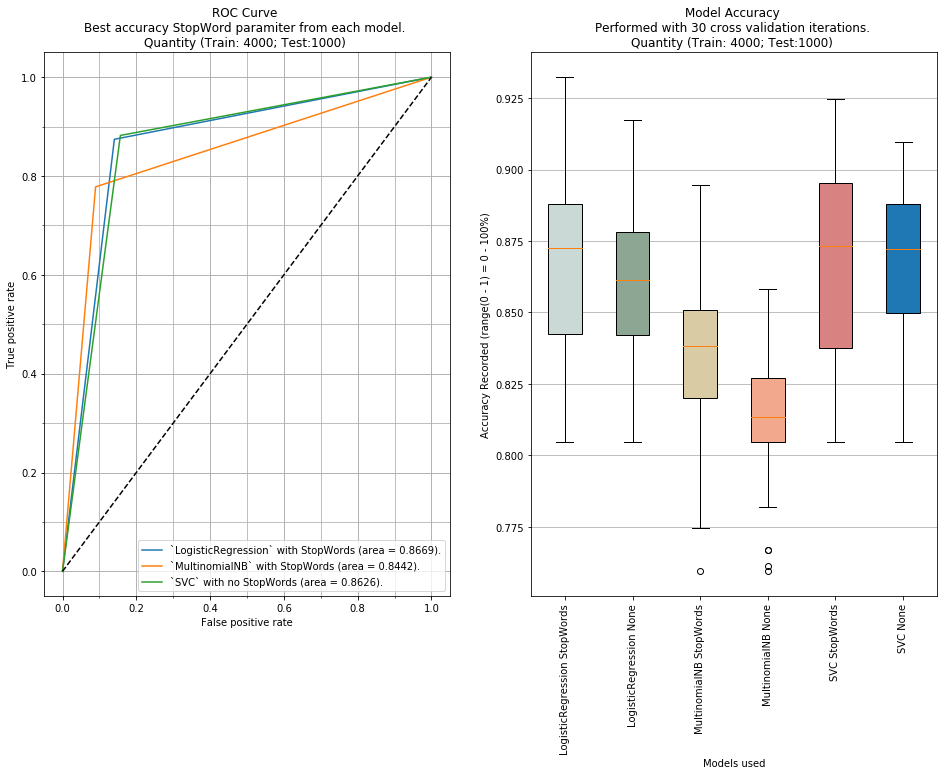

In [21]:
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

for predict in range(0, len(predictions)):
    fpr, tpr, threshold = roc_curve(y_test, predictions[predict]) 

# This is the AUC
    the_auc = auc(fpr, tpr)
# This is the ROC curve
    if best_settings[predict]:
        plot_label = "`" + raw_names[predict] + "` with StopWords (area = "+str(round(the_auc, 4))+")."
    else:
        plot_label = "`" + raw_names[predict] + "` with no StopWords (area = "+str(round(the_auc, 4))+")."
    axes[0].plot(fpr,tpr, label=plot_label % (the_auc))
    
axes[0].plot([0, 1], [0, 1], 'k--') # diagonal

axes[0].set_title('ROC Curve \n'+
                  'Best accuracy StopWord paramiter from each model. \n' +
                 'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend(loc='best')
axes[0].xaxis.grid(True)

spacing = 0.1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)

axes[0].yaxis.set_minor_locator(minorLocator)
axes[0].xaxis.set_minor_locator(minorLocator)
axes[0].grid(which = 'minor')


# box plot

bplot2 = axes[1].boxplot(cv_results,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=names
                         )  # will be used to label x-ticks
axes[1].set_title('Model Accuracy \n'+ 
                  'Performed with ' + str(cross_validation_iterations) +' cross validation iterations. \n' + 
                  'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')

axes[1].set_xlabel('Models used')
axes[1].set_ylabel('Accuracy Recorded (range(0 - 1) = 0 - 100%)')

# fill with colors
colors = ['#CBD9D6', '#8DA593', '#D9CBA3', '#F2A88C', '#D98282']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)

    
    
plt.xticks(rotation=90)
plt.show()

In [33]:
tfidf.get_feature_names

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)>